# AIA Data Reduction Pipeline Test

In [1]:
import sys
import logging
import time
from socket import gethostname

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.instr.aia import aiaprep
import astropy.units as u
import drms
import dask
import dask.array as da
from dask_jobqueue import PBSCluster
import distributed
from sunpy.util.metadata import MetaDict
import astropy.io
from astropy.coordinates import SkyCoord
from astropy.io.fits.hdu.base import BITPIX2DTYPE
import sunpy
from astropy.time import Time

sys.path.append('../scripts/')
from drms_on_ames import Client

%matplotlib inline

In [2]:
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

First, spin up a Dask cluster using the Dask jobqueue functionality.

In [3]:
GID_SDO = 'n1902'

In [4]:
cluster = PBSCluster(
    cores=10,
    processes=1,
    memory="64GB",
    interface="ib0",
    resource_spec='select=1:ncpus=20:mpiprocs=5:model=ivy',
    walltime='00:20:00',
    job_extra=[f'-W group_list={GID_SDO}']
)
#cluster = distributed.LocalCluster()

In [5]:
client = distributed.Client(cluster)

In [6]:
client

<Client: scheduler='tcp://10.150.27.122:46374' processes=0 cores=0>

## Get Files

List the maps we are interested in using `drms`. We will only look at a small subset for now.

In [7]:
c = Client()

In [8]:
c.series()

['aia.lev1',
 'aia.lev1_euv_12s',
 'aia_test.lev1_12s4arc',
 'cgem.lorentz',
 'cgem.pdfi_input',
 'cgem.pdfi_output',
 'hmi.m_45s',
 'hmi.m_720s',
 'hmi.v_45s',
 'hmi.v_720s',
 'hmi.v_avg120']

In [9]:
keys,filenames = c.query(
    'aia_test.lev1_12s4arc[2010-09-29T17:00:00/1h@12s]',
    seg=['image_lev1'],key=['WAVELNTH']
)

../scripts/drms_on_ames.py:57: UserWarning: Unable to open lock file for writing: /home/jsoc/exports/tmp/lock.txt.
Failed to open file for locking /home/jsoc/exports/Web_request_handles.lck.

  warnings.warn(r.stderr.decode('utf-8'))
../scripts/drms_on_ames.py:57: UserWarning: Failed to open file for locking /home/jsoc/exports/Web_request_handles.lck.

  warnings.warn(r.stderr.decode('utf-8'))


Select the wavelengths we want.

In [10]:
file_list_94 = filenames[keys['WAVELNTH']==94].values.squeeze().tolist()

In [11]:
file_list_211 = filenames[keys['WAVELNTH']==211].values.squeeze().tolist()

## Data Structure Definitions

In [12]:
def validate_dtype_shape(head):
    naxes = head['NAXIS']
    dtype = BITPIX2DTYPE[head['BITPIX']]
    shape = [head[f'NAXIS{n}'] for n in range(naxes, 0, -1)]
    return dtype, shape


def get_header(fn, hdu=0):
    with fn as fi:
        return MetaDict(sunpy.io.fits.get_header(fi)[hdu])


class DelayedFITS:
    def __init__(self, file, shape, dtype, hdu=0, verify=False):
        self.shape = shape
        self.dtype = np.dtype(dtype)
        self.file = file
        self.hdu = hdu
        self.verify = verify

    def __getitem__(self, item):
        with self.file as fi:
            with astropy.io.fits.open(fi, memmap=True) as hdul:
                if self.verify:
                    hdul.verify('silentfix+warn')
                return hdul[self.hdu].data[item]

In [13]:
class AIACube(object):

    def __init__(self, maps):
        if not all([m.data.shape == maps[0].data.shape for m in maps]):
            raise ValueError('All maps must have same dimensions')
        if not all([m.data.dtype == maps[0].data.dtype for m in maps]):
            raise ValueError('All maps must have same dtype')
        self.maps = maps
        self.time = self._get_time()

    @classmethod
    def from_files(cls, fits_files, **kwargs):
        openfiles = dask.bytes.open_files(fits_files)
        headers = cls._get_headers(openfiles, **kwargs)
        dtype, shape = cls._get_dtype_and_shape(headers)
        maps = cls._get_maps(openfiles, headers, dtype, shape, **kwargs)
        return cls(maps)

    @staticmethod
    def _get_maps(openfiles, headers, dtype, shape, **kwargs):
        hdu = kwargs.get('hdu', 0)
        verify = kwargs.get('verify', False)
        arrays = [da.from_array(DelayedFITS(f, shape, dtype, hdu=hdu, verify=verify), chunks=shape)
                  for f in openfiles]
        return [sunpy.map.Map(a, h) for a, h in zip(arrays, headers)]

    @staticmethod
    def _get_headers(openfiles, **kwargs):
        client = distributed.get_client()
        futures = client.map(get_header, openfiles, hdu=kwargs.get('hdu', 0))
        return client.gather(futures)

    @staticmethod
    def _get_dtype_and_shape(headers):
        dtypes = [validate_dtype_shape(h) for h in headers]
        if not all([d == dtypes[0] for d in dtypes]):
            raise ValueError('All maps must have same shape and dtype')
        return dtypes[0]

    def _get_time(self,):
        return u.Quantity([(Time(m.meta['t_obs']) - Time(self.maps[0].meta['t_obs'])).to(u.s) 
                            for m in self.maps])

    @property
    def shape(self,):
        return self.time.shape + self.maps[0].data.shape

    @property
    def dtype(self,):
        return self.maps[0].data.dtype

    @property
    def unstacked_data(self,):
        return [m.data for m in self.maps]

    @property
    def stacked_data(self,):
        return da.stack(self.unstacked_data).astype(self.dtype)

    def rechunk(self, shape):
        return self.stacked_data.rechunk(shape)

    def average(self, **kwargs):
        #chunks = kwargs.get('chunks', (self.shape[0], self.shape[1]//10, self.shape[2]//10))
        #cube = self.rechunk(chunks)
        return sunpy.map.Map(self.stacked_data.mean(axis=0, dtype=np.float64), self.maps[0].meta.copy())

    def submap(self, *args, **kwargs):
        return AIACube([m.submap(*args, **kwargs) for m in self.maps])

In [14]:
class AIATimelags(object):
    def __init__(self, *args, **kwargs):
        if not all([a.shape[1:] == args[0].shape[1:] for a in args]):
            raise ValueError('All spatial dimensions must be the same')
        if not all([a.shape[0] == args[0].shape[0] for a in args]):
            warnings.warn('Time dimensions are not all equal length')
        self._cubes = {a.maps[0].meta['wavelnth']: a for a in args}
        self.channels = sorted(list(self._cubes.keys()), key=lambda x: x)

    def __getitem__(self, channel):
        # Index
        if type(channel) is int and channel not in self.channels:
            channel = self.channels[channel]
        # Convert from string
        if type(channel) is str:
            channel = float(channel)
        return self._cubes[channel]
    
    @property
    def needs_interpolation(self,):
        if not all([c.shape[0] == self[0].shape[0] for c in self]):
            return True
        return ~np.all([u.allclose(c.time, self[0].time) for c in self])

    @property
    def timelags(self):
        time = self._interpolate_time if self.needs_interpolation else self[0].time
        delta_t = np.diff(time.value).cumsum()
        return np.hstack([-delta_t[::-1], np.array([0]), delta_t]) * time.unit
    
    @property
    def _interpolate_time(self,):
        min_t = min([c.time.min() for c in self])
        max_t = max([c.time.max() for c in self])
        n_t = max([c.time.shape[0] for c in self])
        return np.linspace(min_t, max_t, n_t)
    
    def _interpolate(self, time, cube):
        t_interp = self._interpolate_time
        def interp_wrapper(y):
            return interp1d(time, y, axis=0, kind='linear', fill_value='extrapolate')(t_interp)
        return da.map_blocks(interp_wrapper, cube, chunks=t_interp.shape+cube.chunks[1:],
                             dtype=cube.dtype)

    def cross_correlation(self, channel_a, channel_b, **kwargs):
        # Shape must be the same in spatial direction
        chunks = kwargs.get('chunks', (self[channel_a].shape[1]//10,
                                       self[channel_a].shape[2]//10))
        cube_a = self[channel_a].rechunk(self[channel_a].shape[:1]+chunks)
        cube_b = self[channel_b].rechunk(self[channel_b].shape[:1]+chunks)
        #if self.needs_interpolation:
        #    cube_a = self._interpolate(self[channel_a].time, cube_a)
        #    cube_b = self._interpolate(self[channel_b].time, cube_b)
        # Reverse the first timeseries
        cube_a = cube_a[::-1, :, :]
        # Normalize by mean and standard deviation
        std_a = cube_a.std(axis=0)
        std_a = da.where(std_a == 0, 1, std_a)
        v_a = (cube_a - cube_a.mean(axis=0)[np.newaxis, :, :]) / std_a[np.newaxis, :, :]
        std_b = cube_b.std(axis=0)
        std_b = da.where(std_b == 0, 1, std_b)
        v_b = (cube_b - cube_b.mean(axis=0)[np.newaxis, :, :]) / std_b[np.newaxis, :, :]
        # FFT of both channels
        fft_a = da.fft.rfft(v_a, axis=0, n=self.timelags.shape[0])
        fft_b = da.fft.rfft(v_b, axis=0, n=self.timelags.shape[0])
        # Inverse of product of FFTS to get cross-correlation (by convolution theorem)
        cc = da.fft.irfft(fft_a * fft_b, axis=0, n=self.timelags.shape[0])
        # Normalize by the length of the timeseries
        return cc / cube_a.shape[0]

    def make_correlation_map(self, channel_a, channel_b, **kwargs):
        cc = self.cross_correlation(channel_a, channel_b, **kwargs)
        bounds = kwargs.get('timelag_bounds', None)
        if bounds is not None:
            indices, = np.where(np.logical_and(self.timelags >= bounds[0],
                                               self.timelags <= bounds[1]))
            start = indices[0]
            stop = indices[-1] + 1
        else:
            start = 0
            stop = self.timelags.shape[0] + 1
        max_cc = cc[start:stop, :, :].max(axis=0).compute()
        meta = self[channel_a].maps[0].meta.copy()
        del meta['instrume']
        del meta['t_obs']
        del meta['wavelnth']
        meta['bunit'] = ''
        meta['comment'] = f'{channel_a}-{channel_b} cross-correlation'
        plot_settings = {'cmap': 'plasma'}
        plot_settings.update(kwargs.get('plot_settings', {}))
        correlation_map = sunpy.map.GenericMap(max_cc, meta, plot_settings=plot_settings)

        return correlation_map

    def make_timelag_map(self, channel_a, channel_b, **kwargs):
        cc = self.cross_correlation(channel_a, channel_b, **kwargs)
        bounds = kwargs.get('timelag_bounds', None)
        if bounds is not None:
            indices, = np.where(np.logical_and(self.timelags >= bounds[0],
                                               self.timelags <= bounds[1]))
            start = indices[0]
            stop = indices[-1] + 1
        else:
            start = 0
            stop = self.timelags.shape[0] + 1
        i_max_cc = cc[start:stop, :, :].argmax(axis=0).compute()
        max_timelag = self.timelags[start:stop][i_max_cc]
        meta = self[channel_a].maps[0].meta.copy()
        del meta['instrume']
        del meta['t_obs']
        del meta['wavelnth']
        meta['bunit'] = 's'
        meta['comment'] = f'{channel_a}-{channel_b} timelag'
        plot_settings = {'cmap': 'RdBu_r', 'vmin': self.timelags[start:stop].value.min(),
                         'vmax': self.timelags[start:stop].value.max()}
        plot_settings.update(kwargs.get('plot_settings', {}))
        timelag_map = sunpy.map.GenericMap(max_timelag, meta.copy(),
                                           plot_settings=plot_settings.copy())
        return timelag_map

## Testing Out a Collection of Maps

The three primary actions we want to explore on a loose collection of maps are:

* prep
* derotate
* crop (or submap)

Ideally, we can build up a series of Dask actions on each of these maps. Each DAG is just a chain in this case as there is no interaction between maps at this stage.

## Stacking Maps into A Cube

In [15]:
cluster.scale_up(4)

In [15]:
cluster.stop_all_jobs()

In [16]:
cube94 = AIACube.from_files(file_list_94, hdu=1, verify=True)

In [18]:
cube94.stacked_data

dask.array<astype, shape=(299, 4096, 4096), dtype=int16, chunksize=(1, 4096, 4096)>

In [15]:
cube94.shape

(299, 4096, 4096)

In [16]:
cube94.dtype

dtype('int16')

<Figure size 864x864 with 0 Axes>

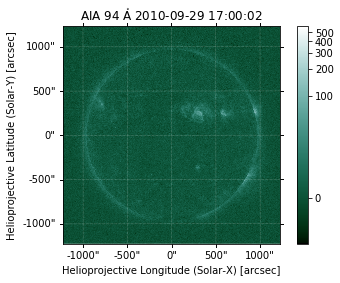

In [17]:
plt.figure(figsize=(12,12))
cube94.maps[0].peek()

In [24]:
foo = cube94.rechunk(cube94.shape[:1]+(10,10))[:,200:250,200:250]

In [25]:
foo

dask.array<getitem, shape=(299, 50, 50), dtype=int16, chunksize=(299, 10, 10)>

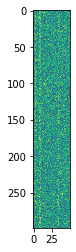

In [27]:
plt.imshow(foo[:,:,0])

In [30]:
cube211 = AIACube.from_files(file_list_211, hdu=1, verify=True)

## Calculate Time Lags

In [31]:
tl = AIATimelags(cube94,cube211)

In [33]:
cluster.scale_up(10)

In [47]:
tl[94].rechunk(tl[94].shape[:1]+(500,500))

dask.array<rechunk-merge, shape=(299, 4096, 4096), dtype=int16, chunksize=(299, 500, 500)>

In [41]:
tl_94_211 = tl.make_timelag_map(
    94,211,
    timelag_bounds=(-3*u.hour,3*u.hour),
    chunks=(500,500),
)

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


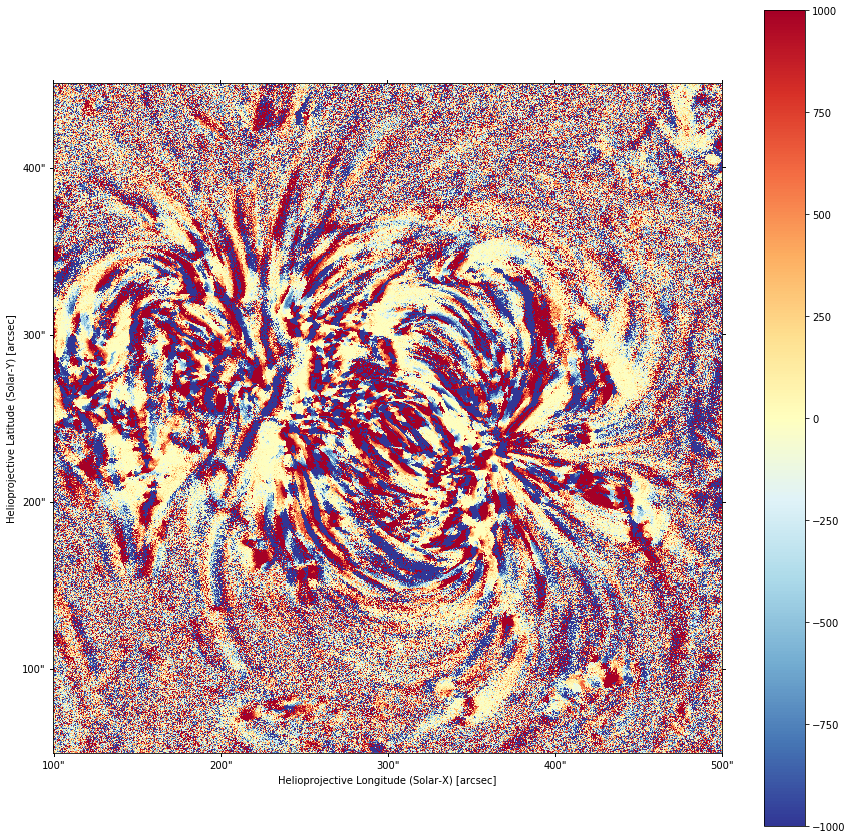

In [40]:
sm = tl_94_211.submap(
    SkyCoord(100*u.arcsec,50*u.arcsec,frame=tl_94_211.coordinate_frame),
    SkyCoord(500*u.arcsec,450*u.arcsec,frame=tl_94_211.coordinate_frame),
)
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection=sm)
im = sm.plot(axes=ax,vmin=-1e3,vmax=1e3,cmap='RdYlBu_r',title=False)
ax.grid(alpha=0)
fig.colorbar(im)

What about a difference image?

In [43]:
diff94 = da.diff(cube94.rechunk(cube94.shape[:1]+(500,500)),axis=0)

In [49]:
diff94_map = sunpy.map.Map(diff94[0,:,:].compute(),cube94.maps[0].meta)

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

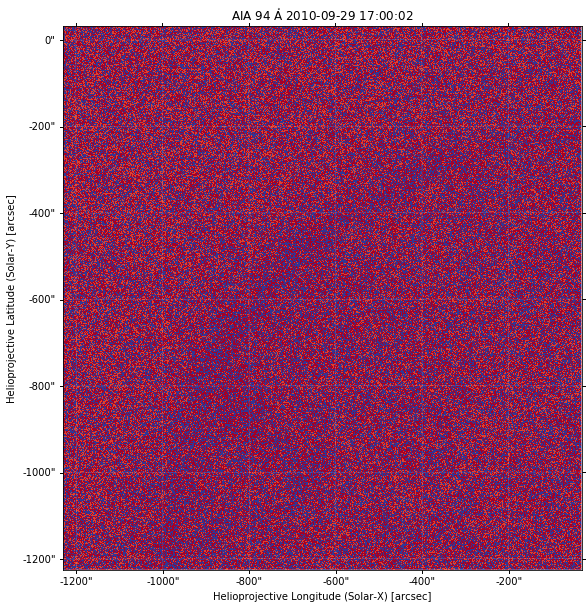

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=diff94_map)
diff94_map.plot(axes=ax,cmap='RdYlBu_r',vmin=-1,vmax=1)

## Sandbox

In [113]:
foo = da.stack([da.from_array(np.random.rand(500,500)) for _ in range(15)])

In [114]:
foo

dask.array<stack, shape=(15, 500, 500), dtype=float64, chunksize=(1, 500, 500)>

In [78]:
foo = foo.rechunk(foo.shape[:1] + (foo.shape[1]//10,foo.shape[2]//10))

In [79]:
foo

dask.array<rechunk-merge, shape=(15, 500, 500), dtype=float64, chunksize=(15, 50, 50)>

In [80]:
foo = foo[::-1,:,:]

In [81]:
foo

dask.array<getitem, shape=(15, 500, 500), dtype=float64, chunksize=(15, 50, 50)>

In [82]:
foo.std(axis=0)

dask.array<sqrt, shape=(500, 500), dtype=float64, chunksize=(50, 50)>

In [115]:
cube94.maps[0].data

dask.array<array, shape=(4096, 4096), dtype=int16, chunksize=(4096, 4096)>

In [119]:
da.stack([m.data for m in cube94.maps],axis=0).astype(cube94.maps[0].data.dtype)

dask.array<astype, shape=(15, 4096, 4096), dtype=int16, chunksize=(1, 4096, 4096)>